#### Loading with Pandas

In [1]:
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

2024-01-11 13:54:55.858876: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 13:54:55.884261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 13:54:55.884283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 13:54:55.884888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 13:54:55.889106: I tensorflow/core/platform/cpu_feature_guar

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
df = pd.read_csv(csv_file)
df.head()

13273/13273 [==============================] - 0s 1us/step


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [4]:
target = df.pop('target')

#### Dataframe as an array
- If the data has a uniform `dtype`, the DataFrame basically works like a numpy array
- `tf.convert_to_tensor` can be used on it
- If it can be converted, than it can probably be used anywere a `Tensor` can

In [5]:
numeric_feature_names = ['age', 'thalach', 'trestbps', 'chol', 'oldpeak']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


In [6]:
tf.convert_to_tensor(numeric_features)

2024-01-11 14:03:53.994499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:03:54.016570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:03:54.016606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:03:54.018943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:03:54.018977: I external/local_xla/xla/stream_executor

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]])>

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)
# Call on 1st 3 rows if the DF
normalizer(numeric_features.iloc[:3])

2024-01-11 14:21:15.363219: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.26008663,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573877 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.33687714,  1.3259765 ]],
      dtype=float32)>

In [8]:
# Use the normalization layer as the first layer of a simple model
def get_basic_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [9]:
model = get_basic_model()
model.fit(numeric_features, target, epochs=15)

Epoch 1/15


2024-01-11 14:26:39.160603: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f24b85689c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 14:26:39.160642: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-01-11 14:26:39.164929: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-11 14:26:39.181445: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1705011999.248315   45326 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 1s 8ms/step - loss: 0.7251 - accuracy: 0.7228
Epoch 2/15
10/10 [==============================] - 0s 7ms/step - loss: 0.7021 - accuracy: 0.7195
Epoch 3/15
10/10 [==============================] - 0s 6ms/step - loss: 0.6814 - accuracy: 0.7228
Epoch 4/15
10/10 [==============================] - 0s 6ms/step - loss: 0.6637 - accuracy: 0.7228
Epoch 5/15
10/10 [==============================] - 0s 6ms/step - loss: 0.6458 - accuracy: 0.7228
Epoch 6/15
10/10 [==============================] - 0s 6ms/step - loss: 0.6302 - accuracy: 0.7261
Epoch 7/15
10/10 [==============================] - 0s 6ms/step - loss: 0.6147 - accuracy: 0.7261
Epoch 8/15
10/10 [==============================] - 0s 6ms/step - loss: 0.5994 - accuracy: 0.7294
Epoch 9/15
10/10 [==============================] - 0s 5ms/step - loss: 0.5845 - accuracy: 0.7327
Epoch 10/15
10/10 [==============================] - 0s 5ms/step - loss: 0.5709 - accuracy: 0.7327
Epoch 11/15
10/10 [===========

#### With tf.data

In [10]:
numeric_ds = tf.data.Dataset.from_tensor_slices((numeric_features, target))

for row in numeric_ds.take(3):
    print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [11]:
numeric_batches = numeric_ds.shuffle(1000).batch(BATCH_SIZE)
model = get_basic_model()
model.fit(numeric_batches, epochs=15)

Epoch 1/15
152/152 [==============================] - 2s 8ms/step - loss: 0.7054 - accuracy: 0.7228
Epoch 2/15
152/152 [==============================] - 1s 5ms/step - loss: 0.6211 - accuracy: 0.7360
Epoch 3/15
152/152 [==============================] - 1s 5ms/step - loss: 0.5461 - accuracy: 0.7327
Epoch 4/15
152/152 [==============================] - 1s 5ms/step - loss: 0.4871 - accuracy: 0.7558
Epoch 5/15
152/152 [==============================] - 1s 5ms/step - loss: 0.4541 - accuracy: 0.7690
Epoch 6/15
152/152 [==============================] - 1s 5ms/step - loss: 0.4403 - accuracy: 0.7822
Epoch 7/15
152/152 [==============================] - 1s 5ms/step - loss: 0.4339 - accuracy: 0.7921
Epoch 8/15
152/152 [==============================] - 1s 4ms/step - loss: 0.4298 - accuracy: 0.7789
Epoch 9/15
152/152 [==============================] - 1s 4ms/step - loss: 0.4266 - accuracy: 0.7888
Epoch 10/15
152/152 [==============================] - 1s 5ms/step - loss: 0.4254 - accuracy: 0.7954

#### Dataframe as a dictionary

In [12]:
numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))
for row in numeric_dict_ds.take(3):
    print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


#### Dictionaries with Keras
- Keras can accept and return nested structures of dictionaries, tuples, and tensors. These structured nests are `tf.nest`
- Dictionaries can be accepted as input through model subclassing or using the Keras functional API

Keras Dictonaries: Model Subclassing

In [13]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))
    return fun(values, axis=-1)

In [25]:
class MyModel(tf.keras.Model):
    def __init__(self):
        # Create internal layers in initialization
        super().__init__()

        self.normalizer = tf.keras.layers.Normalization(axis=-1)

        self.seq = tf.keras.Sequential([
            self.normalizer,
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def adapt(self, inputs):
        # Stack the inputs and adapt the normalization layer
        inputs = stack_dict(inputs)
        self.normalizer.adapt(inputs)
    
    def call(self, inputs):
        # Stack the inputs
        inputs = stack_dict(inputs)
        # Run them through all layers
        result = self.seq(inputs)
        return result
        
model = MyModel()
model.adapt(dict(numeric_features))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

In [26]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 3s 18ms/step - loss: 0.6903 - accuracy: 0.7030
Epoch 2/5
152/152 [==============================] - 3s 19ms/step - loss: 0.5960 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 3s 20ms/step - loss: 0.5344 - accuracy: 0.7294
Epoch 4/5
152/152 [==============================] - 3s 18ms/step - loss: 0.4911 - accuracy: 0.7459
Epoch 5/5
152/152 [==============================] - 3s 19ms/step - loss: 0.4624 - accuracy: 0.7723


In [27]:
# Set up in batches
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 [==============================] - 3s 19ms/step - loss: 0.4503 - accuracy: 0.7789
Epoch 2/5
152/152 [==============================] - 3s 18ms/step - loss: 0.4412 - accuracy: 0.7789
Epoch 3/5
152/152 [==============================] - 3s 19ms/step - loss: 0.4360 - accuracy: 0.7888
Epoch 4/5
152/152 [==============================] - 3s 19ms/step - loss: 0.4326 - accuracy: 0.7789
Epoch 5/5
152/152 [==============================] - 3s 19ms/step - loss: 0.4303 - accuracy: 0.7888


In [28]:
# Predictions on 1st 3 features
model.predict(dict(numeric_features.iloc[:3]))

1/1 [==============================] - 0s 29ms/step


array([[[0.24956343]],

       [[0.9672456 ]],

       [[0.66580594]]], dtype=float32)

Keras Dictonaries: Functional API

In [29]:
inputs = {}
for name, column in numeric_features.items():
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=tf.float32)
inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>}

In [32]:
x = stack_dict(inputs, fun=tf.concat)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

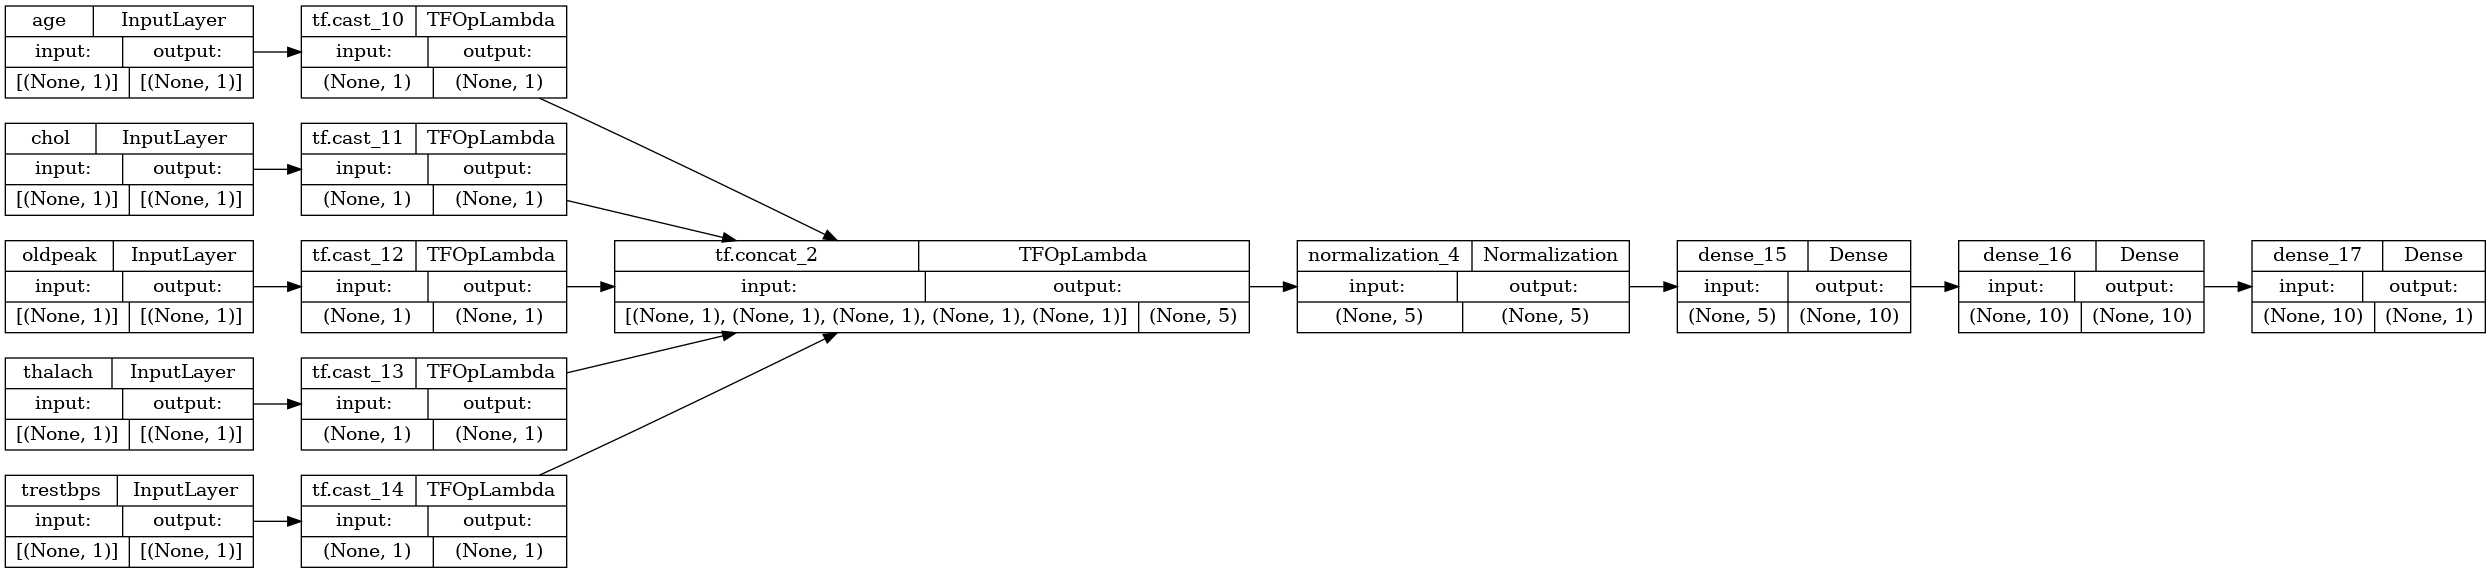

In [33]:
tf.keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

In [34]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 4s 23ms/step - loss: 0.5827 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 3s 21ms/step - loss: 0.5303 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 3s 19ms/step - loss: 0.5063 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 3s 18ms/step - loss: 0.4908 - accuracy: 0.7261
Epoch 5/5
152/152 [==============================] - 3s 17ms/step - loss: 0.4801 - accuracy: 0.7261


#### Full Example
- Use Keras Preprocessing layers to standardize data preprocessing before modeling
- If passing heterogeneous data, each column may need unique processing
- If many features need identical processing, it's more efficient to concat the features together before preprocessing

In [36]:
# Binary features don't need to be encoded or normalized
binary_features = ['sex', 'fbs', 'exang']
categorical_features = ['cp', 'restecg', 'slope', 'thal', 'ca']

In [38]:
# Build the preprocessing model
inputs = {}
for name, column in df.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif (name in categorical_features or name in binary_features):
        dtype = tf.int64
    else:
        dtype = tf.float32
    
    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

Binary Inputs

Each feature starts as a batch of scalars `(shape=(batch, ))`. The output for each should be a batch of `tf.float32` vectors of `(shape=(batch, n))`
The last step will concat all these vectors together

In [42]:
preprocessed = []

for name in binary_features:
    inp = inputs[name]
    inp = inp[:, tf.newaxis] # Add vector axis
    float_value = tf.cast(inp, tf.float32) # Cast to float
    preprocessed.append(float_value) # Add to list of preprocessed inputs

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_18')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_19')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_20')>]

Numeric Inputs

Run through `tf.keras.layers.Normalization` layer, taking input as a dict and adapting the normalization layer

In [43]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

In [46]:
numeric_inputs = {}
for name in numeric_features:
    numeric_inputs[name] = inputs[name]

display(numeric_inputs)
numeric_inputs = stack_dict(numeric_inputs)
display(numeric_inputs)
numeric_normal = normalizer(numeric_inputs)
preprocessed.append(numeric_normal)

preprocessed

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>}

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'tf.stack_2')>

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_18')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_19')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_20')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_5')>]

Categorical Features

Categorical features must be econded into binary vectors or embeddings. They will be converted into one hot with `tf.keras.layers`; `StringLookup` and `IntegerLookup` 

In [48]:
# How they work
vocab = ['a', 'b', 'c']
lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
lookup(['c', 'a', 'a', 'b', 'zzz'])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [49]:
vocab = [1, 4, 7 ,99]
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
lookup([-1, 4, 1])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [51]:
# Now create that one hot layer for the vocab
for name in categorical_features:
    vocab = sorted(set(df[name]))
    print(f'name: {name}')
    print(f'vocab: {vocab}')

    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    else:
         lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

    x = inputs[name][:, tf.newaxis]
    x = lookup(x)
    preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]
name: restecg
vocab: [0, 1, 2]
name: slope
vocab: [1, 2, 3]
name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']
name: ca
vocab: [0, 1, 2, 3]


In [52]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_18')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_19')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_20')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_4')>]

Concat all preprocessed features and model

In [53]:
prep_result = tf.concat(preprocessed, axis=-1)
prep_result

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat_3')>

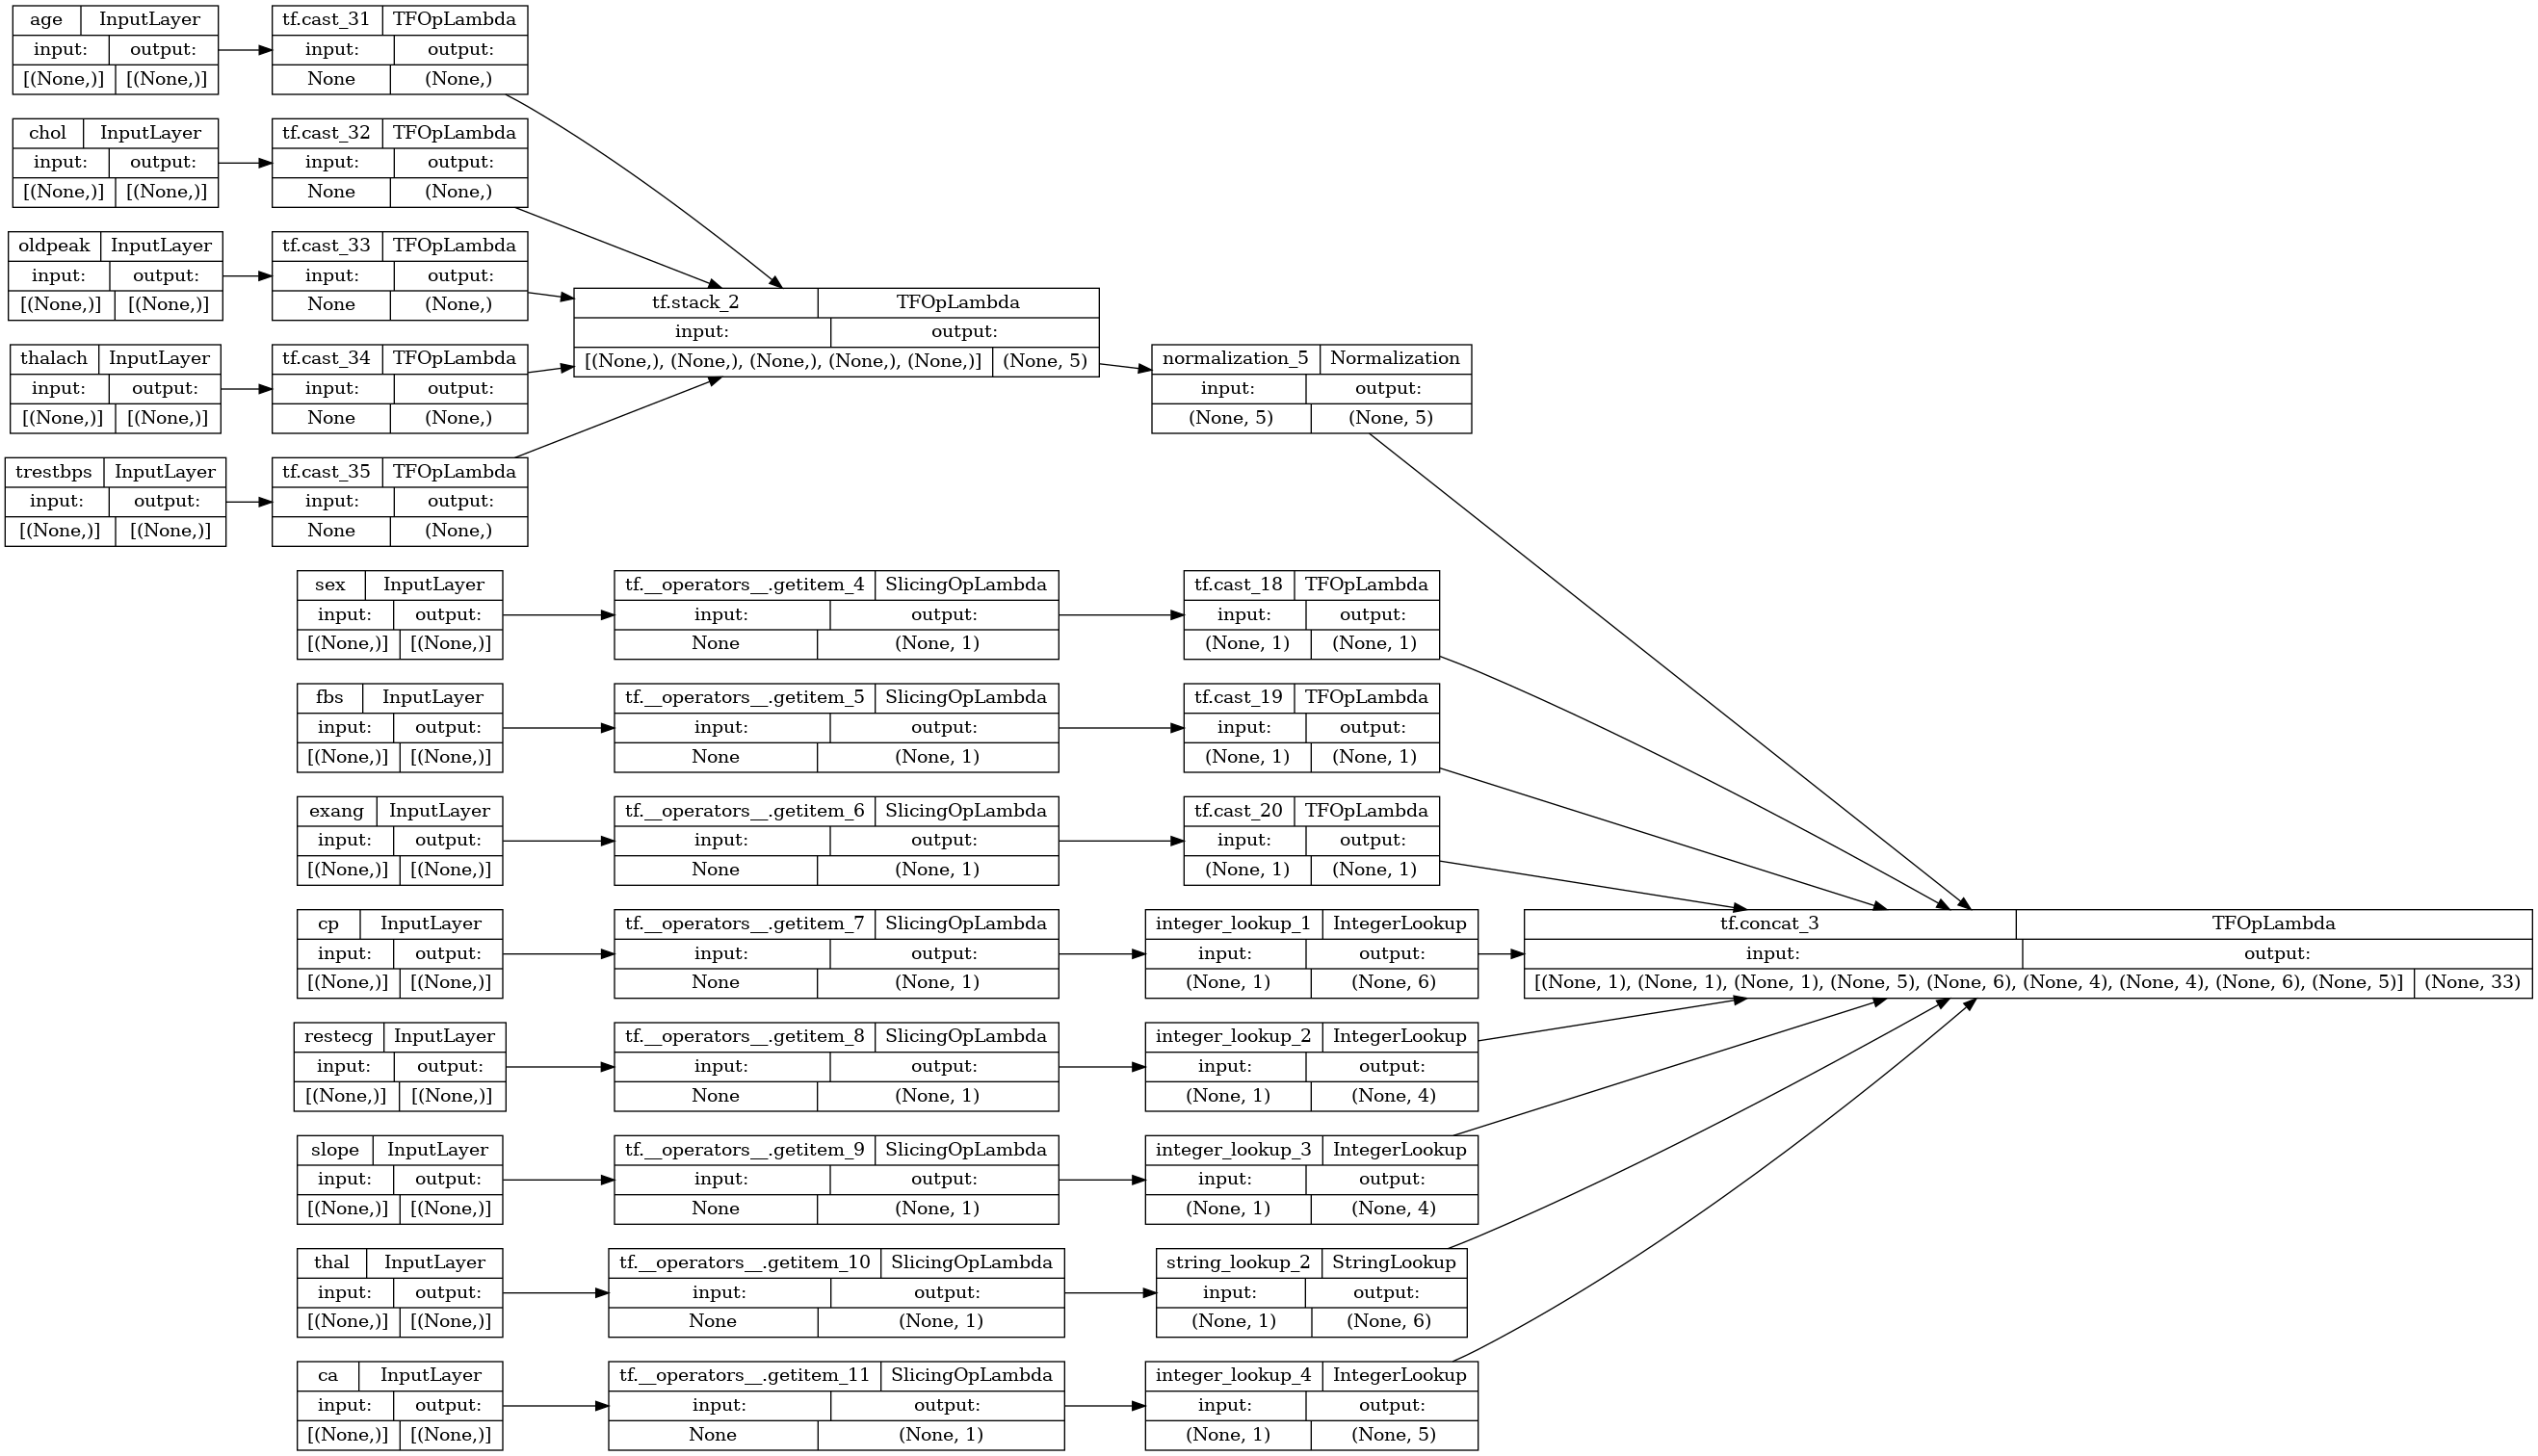

In [54]:
preprocessor = tf.keras.Model(inputs, prep_result)
tf.keras.utils.plot_model(preprocessor, rankdir='LR', show_shapes=True)

In [55]:
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 1.        ,  1.        ,  0.        ,  0.93383914, -0.26008663,
         1.0680453 ,  0.03480718,  0.74578077,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)>

In [56]:
body = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [57]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model_1')>

In [59]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_5')>

In [61]:
model = tf.keras.Model(inputs, result)
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [62]:
history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 2s 9ms/step - loss: 0.6668 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 1s 10ms/step - loss: 0.5150 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 1s 9ms/step - loss: 0.4012 - accuracy: 0.7327
Epoch 4/5
152/152 [==============================] - 1s 10ms/step - loss: 0.3446 - accuracy: 0.8020
Epoch 5/5
152/152 [==============================] - 1s 9ms/step - loss: 0.3118 - accuracy: 0.8317


In [63]:
# Can also use tf.data
ds = tf.data.Dataset.from_tensor_slices((
    dict(df),
    target
))

ds = ds.batch(BATCH_SIZE)

In [64]:
import pprint

for x,y in ds.take(1):
    pprint.pprint(x)
    print()
    print(y)

{'age': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([63, 67])>,
 'ca': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>,
 'chol': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([233, 286])>,
 'cp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 4])>,
 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>,
 'oldpeak': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.3, 1.5])>,
 'restecg': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>,
 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>,
 'slope': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 2])>,
 'thal': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'fixed', b'normal'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([150, 108])>,
 'trestbps': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([145, 160])>}

tf.Tensor([0 1], shape=(2,), dtype=int64)


In [65]:
history = model.fit(ds, epochs=5)

Epoch 1/5
152/152 [==============================] - 2s 11ms/step - loss: 0.2945 - accuracy: 0.8548
Epoch 2/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2829 - accuracy: 0.8614
Epoch 3/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2741 - accuracy: 0.8746
Epoch 4/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2669 - accuracy: 0.8746
Epoch 5/5
152/152 [==============================] - 1s 10ms/step - loss: 0.2603 - accuracy: 0.8713
